In [1]:
from pydent.planner import Planner
from pydent.browser import Browser
from mysession import production

browser = Browser(production)

In [2]:
import networkx as nx

def find_connected_successors(canvas, name1, name2, depth_limit, return_empty=False):
    """Returns connected operations found within the specified depth"""
    G = canvas.layout.G
    edges = []
    for node_id in G.nodes:
        node = G.nodes[node_id]
        op = node['operation']
        op_type_name = op.operation_type.name
        if op_type_name == name1:
            found = []
            for _, next_node_ids in nx.bfs_successors(G, node_id, depth_limit=depth_limit):
                nodes = [G.nodes[nid] for nid in next_node_ids]
                for node2 in nodes:
                    op2 = node2['operation']
                    op_type_name2 = op2.operation_type.name
                    if op_type_name2 == name2:
                        found.append(node2)
            if return_empty:
                edges.append((node, found))
            elif found:
                edges.append((node, found))
    return edges
    
def yeast_qc_status(canvas):
    qc = find_connected_successors(canvas, 'Check Yeast Plate', 'Fragment Analyzing', 4, return_empty=True)
    glycerol = find_connected_successors(canvas, 'Check Yeast Plate', 'Yeast Glycerol Stock', 4, return_empty=True)
    
    sample_dict = {}
    
    for _qc, _glycerol in zip(qc, glycerol):
        check_plate = _qc[0]['operation']
        sample = check_plate.inputs[0].sample
        sample_dict[sample.name] = {
            'check_plate_op_id': check_plate.id,
            'qc': _qc[1],
            'did_pass': any([x['operation'].status == 'done' for x in _qc[1]]),
            'glycerol': _glycerol[1]
        }
    return sample_dict
        

def op_paths(canvas, opid1, opid2, depth=None):
    G = canvas.layout.G
    return list(nx.all_simple_paths(G, opid1, opid2, cutoff=depth))

def ids_to_ops(G, node_ids):
    return [G.nodes[nid]['operation'] for nid in node_ids]

def query_graph(G, query):
    query_func = None
    if isinstance(query, str):
        query_func = lambda op: op.operation_type.name == query
    elif isinstance(query, int):
        query_func = lambda op: op.id == query
    else:
        raise TypeError("Unknown query type")
    passed = []
    for nid in G.nodes:
        node = G.nodes[nid]
        op = node['operation']
        if query_func(op):
            passed.append((nid, node))
    return passed

def get_paths(G, query1, query2, depth=None, return_empty=False, return_orphans=False):
    nodes1 = query_graph(G, query1)
    nodes2 = query_graph(G, query2)
    results = []
    orphans = []
    for n1, _ in nodes1:
        is_orphan = True
        for n2, _ in nodes2:
            all_paths = list(nx.all_simple_paths(G, n1, n2, cutoff=depth))
            if return_empty:
                is_orphan = False
                results.append((n1, n2, all_paths))
            elif all_paths:
                is_orphan = False
                results.append((n1, n2, all_paths))
        if is_orphan:
            orphans.append(n1)
    if return_orphans:
        return results, orphans
    else:
        return results

def status_summary(statuses):
    if 'error' in statuses:
        return 'error'
    elif 'delayed' in statuses:
        return 'delayed'
    elif 'running' in statuses:
        return 'running'
    elif 'pending' in statuses:
        return 'pending'
    elif 'waiting' in statuses:
        return 'waiting'
    elif all([s == 'done' for s in statuses]):
        return 'done'
    else:
        return 'unknown?'

def leg_status(G, path):
    ids_to_ops(G, path)
    op_statuses = [op.status for op in operations]
    if 'error' in op_statuses:
        statuses.append('error')
    elif 'delayed' in op_statuses:
        statuses.append('delayed')
    elif 'running' in op_statuses:
        statuses.append('running')
    elif 'pending' in op_statuses:
        statuses.append('pending')
    elif 'waiting' in op_statuses:
        statuses.append('waiting')
    elif all([s == 'done' for s in op_statuses]):
        statuses.append('done')
    else:
        statuses.append('unknown?')
    return statuses
        
def get_statuses(G, query1, query2, depth=None, return_empty=False):
    path_data, orphans = get_paths(G, query1, query2, depth=depth, return_empty=return_empty, return_orphans=True)
    results = []
    for n1, n2, simple_paths in path_data:
        statuses = [[op.status for op in ids_to_ops(G, path)] for path in simple_paths]
        summary = [status_summary(_s) for _s in statuses]
        results.append((n1, n2, statuses, summary))
    return results, orphans

In [3]:
def canvas_qc_status(canvas, depth=None):
    G = canvas.layout.G
    print(canvas.plan.id)
    status_summary, orphans = get_statuses(G, 'Check Yeast Plate', 'Fragment Analyzing', depth=depth, return_empty=False)
    results = []
    for summary in status_summary:
        node = G.nodes[summary[0]]
        op = node['operation']
        sample = op.outputs[0].sample
        results.append((sample.name, summary))
        
    return results, orphans

canvas = Planner(production, plan_id=30889)
statuses, orphans = canvas_qc_status(canvas, depth=5)
orphans

30889


[]

In [4]:
def set_qc_sample(yeast, p1, p2, length):
    yeast = yeast.session.Sample.find(yeast.id)
    
    print("Updating {} to {} {} {}bp".format(yeast.name, p1.name, p2.name, length))
    json_update = browser._Browser__json_update
    
    yeast.update_properties({
        'QC Primer1': p1,
        'QC Primer2': p2,
        'QC_length': length
    })
    
    fv_dict = yeast._fv_dict()
    qc1 = fv_dict['QC Primer1']
    qc2 = fv_dict['QC Primer2']
    length_fv = fv_dict['QC_length']
    
    json_update(qc1)
    json_update(qc2)
    json_update(length_fv)
    return yeast
    
def colony_pcr(canvas, check_yeast_plate, num, p1, p2, length):
    print("Submitting {} qcs using {} {}".format(num, p1.name, p2.name))
    sample = check_yeast_plate.outputs[0].sample
    set_qc_sample(sample, p1, p2, length)
    for i in range(num):
        ops = canvas.quick_create_chain(check_yeast_plate, 'Yeast Lysate', 'Colony PCR', 'Fragment Analyzing')
        pcr = ops[2]
        canvas.set_field_value(pcr.input("QC Primer1"), sample=p1)
        canvas.set_field_value(pcr.input("QC Primer2"), sample=p2)
        canvas.set_to_available_item(pcr.input("QC Primer1"))
        canvas.set_to_available_item(pcr.input("QC Primer2"))

def submit_qc(canvas, check_plate, ncols=3):
    failed = []
    if check_plate.status == 'error':
        failed.append(check_plate)
        print("Skipping due to error")
        return [], failed
#     elif check_plate.status in :
#         print("Skipping since in , pending or running")
#         return [], failed
    yeast = browser.find(check_plate.inputs[0].child_sample_id)
    plasmid = yeast.properties['Integrant']
    num_colonies = 0
    try:
        num_colonies = check_plate.outputs[0].item.get('num_colonies')
    except Exception as e:
        print(e)
    num_qcs = min(ncols, num_colonies)
    print("NUM QCS: {}".format(num_qcs))
    if num_qcs == 0:
        print("{} failed".format(yeast.name))
    if 'pmod6'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('pInt III206645 URA F'), 
                   browser.find_by_name('P2DT-GPD-R'), 1299)
    elif 'pmod8'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('ColonyPCR_HIS3_F(pMOD)'), 
                   browser.find_by_name('P2DT-GPD-R'), 1281)
    elif 'bleo'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('Fig2_MXmarker_F'), 
                   browser.find_by_name('pr731_pTEF_Rev'), 500)
    elif 'hyg'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('P1G1_HygroMX_F'), 
                   browser.find_by_name('HygMX-R'), 500)
    elif 'LTR1-Nat'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('attB1-NatMX-fwd'), 
                   browser.find_by_name('NatMX-TP-rev'), 500)
    elif 'HOkan'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('HO_outer_left'), 
                   browser.find_by_name('Kan-BIF4p_2F'), 2000)
    elif 'natmx'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find(8805), 
                   browser.find(8806), 500)
    elif 'kanmx'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('IntergrationF_1'), 
                   browser.find_by_name('Kan-BIF4p_2F'), 500)
    elif 'HO'.upper() in plasmid.name.upper():
        colony_pcr(canvas, check_plate, 
                   num_qcs, 
                   browser.find_by_name('HO_outer_left'), 
                   browser.find_by_name('Kan-BIF4p_2F'), 2000)
    else:
        print("{} not recognized".format(plasmid.name))


In [5]:
plan_ids = [33665, 33661]

# submit all others
# remaining 30442, 30383, 30557

for plan_id in plan_ids:
    canvas = Planner(production, plan_id=plan_id)


    statuses, orphans = canvas_qc_status(canvas, depth=5)

    # resubmit script for failed QCs
    grouped = {}
    for s in statuses:
        sname, info = s
        opid = info[0]
        grouped.setdefault(opid, list()).append(s[1])

    for k, info in grouped.items():
        all_errored = all([s[-1][-1] == 'error' for s in info])
        if len(info) < 6 and all_errored:
            op = canvas.find_operation(k)
            submit_qc(canvas, op)

    # submit script for orphaned check plates
    for opid in orphans:
        op = canvas.find_operation(opid)
        submit_qc(canvas, op)
        
    canvas.layout.topo_sort()
    canvas.layout.to_grid(4)
    canvas.layout.draw()
        
    canvas.save()
    canvas.ipython_link()
    

33665
'NoneType' object has no attribute 'get'
NUM QCS: 0
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17 failed
Submitting 0 qcs using ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R
Updating CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17 to ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R 1281bp
'NoneType' object has no attribute 'get'
NUM QCS: 0
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Kanmx-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17 failed
Submitting 0 qcs using ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R
Updating CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Kanmx-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17 to ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R 1281bp
'NoneType' object has no attribute 'get'
NUM QCS: 0
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Kanmx-pGRR-W19-RGR

33661
NUM QCS: 1
Submitting 1 qcs using ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R
Updating CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W5W8-URGR-F1 | pMOD-LTR2-Bleo-pGRR-F1W10-RGR-W8 | pMOD8-pGRR-W8-RGR-W10 to ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R 1281bp
NUM QCS: 3
Submitting 3 qcs using ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R
Updating CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 to ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R 1281bp
'NoneType' object has no attribute 'get'
NUM QCS: 0
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 failed
Submitting 0 qcs using ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R
Updating CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 to ColonyPCR_HIS3_F(pMOD) P2DT-GPD-R 1281bp


In [ ]:
canvas.layout.topo_sort()
canvas.layout.draw()

In [8]:
canvas.save()
canvas.ipython_link()

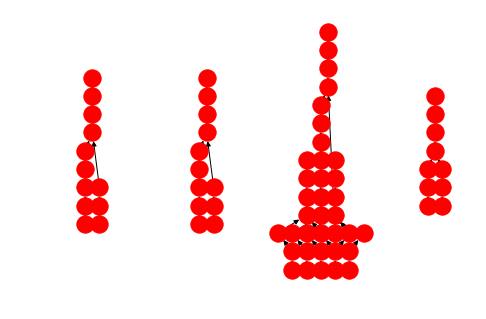

In [37]:
canvas = Planner(production, plan_id=32551)

canvas.layout.topo_sort()
canvas.layout.to_grid(4)
canvas.draw()


In [6]:
canvas = Planner(production, plan_id=32551)

In [16]:
canvas.set_field_value(canvas.find_operation(186049).input("Require QC?"), value="require only prev qc")
canvas.save()
canvas.ipython_link()

In [12]:
ops = canvas.find_operations_by_name("Yeast Overnight Suspension")
for op in ops:
    if op.status == 'delayed':
        print(op.id)
        print(op.input("Require QC?").value)
        print(op.status)

186017
yes
delayed
186049
yes
delayed
186059
yes
delayed


### Replan Yeast Transformation

In [20]:
# replan yeast transformation

canvas = Planner(production, plan_id=32551)

In [23]:
op = canvas.find_operation(185994)

l = canvas.layout
l.s

In [35]:
canvas.ipython_link()

In [13]:
production.set_verbose(False)
loaded = Planner(production, plan_id=30442)
json_update = browser._Browser__json_update
production.set_verbose(True)
for op in loaded.find_operations_by_name("Colony PCR"):
    if op.status == 'waiting':
        
        fv = op.input("QC Primer1")
        if not fv:
            canvas.set_to_available_item(fv)
#         json_update(fv)
        
        fv = op.input("QC Primer2")
        if not fv:
            canvas.set_to_available_item(fv)
        print(fv.sample.name)
        for aft in fv.field_type.allowable_field_types:
            print(aft.raw)
        print(loaded.get_available_items(fv, Planner.ITEM_SELECTION_PREFERENCE.ANY))
        print(fv.child_item_id)

ColonyPCR_URA3_R(pMOD)
{'id': 1183, 'field_type_id': 1065, 'sample_type_id': 1, 'object_type_id': 207, 'created_at': '2017-10-31T20:20:53.000-07:00', 'updated_at': '2017-10-31T20:20:53.000-07:00', 'sample_type': {'id': 1, 'name': 'Primer', 'description': 'A short double stranded piece of DNA for PCR and sequencing', 'created_at': '2013-10-08T10:18:01.000-07:00', 'updated_at': '2015-11-29T07:55:20.000-08:00'}, 'object_type': {'id': 207, 'name': 'Primer Aliquot', 'description': 'Primers at low concentration (10uM) for every day use', 'min': 0, 'max': 1, 'handler': 'sample_container', 'safety': 'No safety information', 'cleanup': 'No cleanup information', 'data': 'No data', 'vendor': 'No vendor information', 'created_at': '2013-10-14T17:03:58.000-07:00', 'updated_at': '2018-08-09T15:13:26.000-07:00', 'unit': 'Primer', 'cost': 0.01, 'release_method': 'return', 'release_description': '', 'sample_type_id': 1, 'image': '', 'prefix': 'M20', 'rows': None, 'columns': None}}


AttributeError: 'AllowableFieldType' object has no attribute 'sample'

In [31]:
loaded.save()
loaded.ipython_link()

In [33]:
# loaded.plan.to_save_json()

{'budget_id': 41,
 'cost_limit': None,
 'created_at': '2018-12-20T16:43:48.000-08:00',
 'folder': '3NodeBistableSwitch',
 'id': 30442,
 'layout': {'children': None,
  'documentation': 'No documentation ofr this module',
  'height': 60,
  'id': 0,
  'input': None,
  'name': 'no_name',
  'output': None,
  'parent_id': -1,
  'text_boxes': None,
  'width': 160,
  'wires': None},
 'name': 'Alpha strains for 3-node bistable switches',
 'operations': [{'created_at': '2018-12-20T16:43:48.000-08:00',
   'field_values': [{'allowable_field_type_id': 1192,
     'child_item_id': 151370,
     'child_sample_id': 3248,
     'child_sample_name': '3248: pMOD6-pGRR-W34-yeGFP',
     'column': None,
     'created_at': '2018-12-20T16:43:48.000-08:00',
     'field_type_id': 1074,
     'id': 666259,
     'name': 'Integrant',
     'parent_class': 'Operation',
     'parent_id': 161282,
     'rid': 386373,
     'role': 'input',
     'row': None,
     'sid': '3248: pMOD6-pGRR-W34-yeGFP',
     'updated_at': '2018-